# US Judge Ideology
## By George Radner and Ian Sapollnik
### ECON 407 Final Assignment
### April 21, 2019

In this project, we assess the following questions:
- How has the ideological position of US Federal District Court Judges changed over time?
- What has driven these changes?
- What influences how judges vote?

This notebook is divided into various parts. Part 1 outlines the data used and cleans the data. Part 2 presents an overview of the data. Part 3 shows overall trends in ideology. Part 4 isolates specific effects. Part 5 looks at how judges make decisions.

# Part 0 - Import Packages

In [10]:
# All packages used in this notebook are imported here.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection, tree
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
from scipy import stats
import statsmodels as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from patsy.builtins import *
from patsy import dmatrices
import statistics as st

#Jellyfish is not included in syzygy. Uncomment if necessary.
#!pip install jellyfish
import jellyfish as jf

# Part 1 - Data Collection and Cleaning

## Attributes of Federal Judges Data

The main dataset for this analysis is the [Attributes of U.S. Federal Judges Database](http://artsandsciences.sc.edu/poli/juri/attributes.htm), from The Judicial Research Initiative (JuRI) at the University of South Carolina. The data was downloaded as a .dta file from the website, but had no data labels or encoding. The labeling file was written only for SAS. Before starting to clean the data in Python, we took the SAS cleaning code and manually changed it into Stata code in order to label the values and clean other portions of the data. After running this through Stata, the data was exported as a .csv file, and we do the final cleaning (everything that could possibly be done in Python) here.

In [12]:
# Load raw data
judge_att_data = pd.read_csv('Judge Attribute Data.csv')

# Here is what it looks like right now
judge_att_data.head()

name_original                       name  songer_code  \
0        Abruzzo, Matthew J.        Abruzzo, Matthew J.      10201.0   
1     Acheson, Marcus Wilson     Acheson, Marcus Wilson          NaN   
2  Acker, William Marsh, Jr.  Acker, William Marsh, Jr.      11101.0   
3    Ackerman, Harold Arnold    Ackerman, Harold Arnold      10301.0   
4      Ackerman, James Waldo      Ackerman, James Waldo      10701.0   

   circuit_original   circuit  id          pres      appres  yearl   yearb  \
0                 2    Second   2  F. Roosevelt    Democrat   1966  1889.0   
1                 3     Third   4         Hayes  Republican   1891  1828.0   
2                11  Eleventh  10        Reagan  Republican   1996  1927.0   
3                 3     Third  15        Carter    Democrat   1994  1928.0   
4                 7   Seventh  20          Ford  Republican   1984  1926.0   

   ...  pmayor pccoun pccom pada pda plother plotherl plawprof pprivate  \
0  ...     NaN    NaN   NaN  NaN NaN     NaN      NaN      NaN      1.0   
1  ...     NaN    NaN   NaN  NaN NaN     NaN      NaN      NaN      1.0   
2  ...     NaN    NaN   NaN  NaN NaN     NaN      NaN      NaN      1.0   
3  ...     NaN    NaN   NaN  NaN NaN     NaN      NaN      NaN      1.0   
4  ...     NaN    NaN   NaN  NaN NaN     1.0      3.0      NaN      1.0   

  recdate  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  

[5 rows x 147 columns]

In [13]:
# Drop unnecessary columns, rename necessary columns 
judge_att_data = judge_att_data.drop(columns = ['name_original','___l','___j','___char','elevate','dcother',
                                                'liable', 'dummy','religion','circuit',
                                                'songer_code','amon','crossl','pred','appt','temp',
                                                'trans','liable','abamin','dsenate','rsenate','dhouse',
                                                'rhouse','fhouse','fsenate','drhouse','drsenate',
                                                'whouse','wsenate','nrhouse','nrsenate','dsens','rsens',
                                                'yeari','yearc','e1','e2','e3','e4','e5','e6','congresi',
                                                'unity','e7','e8','yearo','congreso','unityo','cityb',
                                                'badeg','bastate','bastatus','jddeg','jdstate','jdstatus',
                                                'grad1','grad2','tperm','fsens','drsens','wsens','nrsens',
                                                'osens','agego','service','csb','ba','bast','bapp','ls',
                                                'lsst','jdpp','graddeg1','graddeg2','statecab','state2',
                                                'recdate','ageon'])
judge_att_data = judge_att_data.rename(columns = {'name':'Name','circuit_original':'Circuit','id':'ID',
                                        'pres':'Appointing President','yearl':'Year of Departure',
                                        'yearb':'Year of Birth','yeard':'Year of Death',
                                        'pleft':'President when Departed','left':'Reason for Departing',
                                        'party':'Judge Party','district':'District','state':'State',
                                        'city':'City','gender':'Gender','race':'Race',
                                        'ayear':'Year of Appointment','crossa':'Cross Appointment',
                                        'recess':'Recess Appointment','aba':'ABA Rating',
                                        'assets':'Assets','congress':'Congress','unityi':'Unity',
                                        'hdem':'House Democrats','hrep':'House Republicans',
                                        'sdem':'Senate Democrats','srep':'Senate Republicans',
                                        'hother':'House Independents','sother':'Senate Independents',
                                        'networth':'Net Worth','appres':'Appointing President Party'})

# Replace zero values with missing for net worth and assets
def replace_zero_with_na(x):
    if x == 0:
        return np.nan
    else:
        return x
judge_att_data['Assets'] = judge_att_data['Assets'].apply(replace_zero_with_na)
judge_att_data['Net Worth'] = judge_att_data['Net Worth'].apply(replace_zero_with_na)

# Turn the position indicator columns into dummies and rename (these all start with 'p')
def turn_into_dummy(val):
    if np.isnan(val):
        return 0
    else:
        return 1

position_columns = list(filter(lambda col: col[0] == 'p', list(judge_att_data.columns)))
for col in position_columns:
    judge_att_data[col] = judge_att_data[col].apply(turn_into_dummy)
    judge_att_data = judge_att_data.rename(columns = {col:'Previous Position - ' + col[1:]})
    
# Creating new variable for whether judge held any of the elected positions
# These are the variables for the judge holding elected office of some kind     
political_positions =  ['Previous Position - house', 'Previous Position - senate',
                        'Previous Position - gov','Previous Position - ssenate',
                        'Previous Position - shouse','Previous Position - mayor','Previous Position - ccoun']

# Creating column of 0's which we will then fill
judge_att_data["Politician"] = 0*judge_att_data['Previous Position - house']
for position in political_positions:
    judge_att_data["Politician"] = np.maximum(judge_att_data["Politician"],judge_att_data[position])
    
# Creating new variable for judge's age at the time of appointment
judge_att_data["Age When Appointed"] = judge_att_data["Year of Appointment"] - judge_att_data["Year of Birth"]

# Here is the data now
judge_att_data.head()

Name  Circuit  ID Appointing President  \
0        Abruzzo, Matthew J.        2   2         F. Roosevelt   
1     Acheson, Marcus Wilson        3   4                Hayes   
2  Acker, William Marsh, Jr.       11  10               Reagan   
3    Ackerman, Harold Arnold        3  15               Carter   
4      Ackerman, James Waldo        7  20                 Ford   

  Appointing President Party  Year of Departure  Year of Birth  Year of Death  \
0                   Democrat               1966         1889.0         1971.0   
1                 Republican               1891         1828.0         1906.0   
2                 Republican               1996         1927.0         9999.0   
3                   Democrat               1994         1928.0         9999.0   
4                 Republican               1984         1926.0         1984.0   

  President when Departed Reason for Departing  ... Previous Position - ccoun  \
0            L.B. Johnson              Retired  ...                         0   
1             B. Harrison             Elevated  ...                         0   
2                 Clinton              Retired  ...                         0   
3                 Clinton              Retired  ...                         0   
4                  Reagan                 Died  ...                         0   

  Previous Position - ccom Previous Position - ada Previous Position - da  \
0                        0                       0                      0   
1                        0                       0                      0   
2                        0                       0                      0   
3                        0                       0                      0   
4                        0                       0                      0   

  Previous Position - lother Previous Position - lotherl  \
0                          0                           0   
1                          0                           0   
2                          0                           0   
3                          0                           0   
4                          1                           1   

   Previous Position - lawprof Previous Position - private Politician  \
0                            0                           1          0   
1                            0                           1          0   
2                            0                           1          0   
3                            0                           1          1   
4                            0                           1          0   

   Age When Appointed  
0                47.0  
1                52.0  
2                55.0  
3                51.0  
4                50.0  

[5 rows x 72 columns]

## Judge Ideology Data

We also have data on individual judge ideology scores, which comes from [Christina L Boyd](http://clboyd.net/ideology.html) at the University of Georgia. In this dataset, a negative ideology score is more liberal, while a positive ideology score is more conservative. The scores range from -1 to 1.

The judge names in the two datasets do not match perfectly. As a result, we must fuzzy match the names to obtain a high number matches between the two datasets. To do this, we calculate the [Jaro-Winkler distance](https://en.wikipedia.org/wiki/Jaro%E2%80%93Winkler_distance) between each string in the Judge Attribute Data and the Ideology Data, and take a match for the highest scoring match for each name in the Attribute Data. The Jaro-Winkler distance assigns stronger weights to characters at the beginning of the string. Since the names are in the Last, First M. format, this makes last names more important than first names for the matching, which gives more accurate results. With some manual inspection, we chose 0.89 as the minimum score for an accurate name match.

In [14]:
# Load ideology data
judge_ideo_score = pd.read_excel('Judge Ideology Scores.xlsx')
judge_ideo_score = judge_ideo_score[['judgename','ideology_score']]
judge_ideo_score = judge_ideo_score.rename(columns = {'judgename':'Name','ideology_score':'Ideology Score'})

# Here is what it looks like
judge_ideo_score.head()

Name  Ideology Score
0     Abrams, Leslie Joyce          -0.294
1           Abrams, Ronnie          -0.302
2     Acker, William Marsh           0.407
3  Ackerman, Harold Arnold          -0.306
4    Ackerman, James Waldo           0.061

In [15]:
# Define function for getting the best matching from a given list. We will use this again later on.
def get_best_name_match_from_list(name, data_list):
    best_match = ""
    highest_jw = 0
    
    for potential_match in data_list:
        # This gives the Jaro-Winkler score which we use for matching
        current_score = jf.jaro_winkler(potential_match, name)
        if ((current_score > highest_jw) and (current_score > 0.89)):
            highest_jw = current_score
            best_match = potential_match
    
    return best_match

# Create column of closest name
judge_att_data['Closest Name'] = judge_att_data['Name'].apply(lambda x : get_best_name_match_from_list(x,judge_ideo_score['Name']))
# Here is what some results look like. Note that blanks exist where no match was found.
judge_att_data[['Name','Closest Name']].sample(10)

Name          Closest Name
481        Cote, Denise Louise          Cote, Denise
1438      Martin, John S., Jr.       Martin, John S.
168       Blackburn, Robert E.  Blackburn, Robert E.
1763       Payne, Robert Elkin      Payne, Robert E.
731            Foley, James T.   Foley, James Thomas
1236        Kinkeade, James E.    Kinkeade, James E.
2446  Wilkerson, James Herbert                      
902          Hall, Sam B., Jr.                      
153           Bicks, Alexander      Bicks, Alexander
1424           Marchant, Henry

In [16]:
# Merge ideology data into attribute data using the closest match found
judge_att_data = judge_att_data.merge(judge_ideo_score, left_on = 'Closest Name', right_on = 'Name', how = 'left')
judge_att_data = judge_att_data.drop(columns = ['Name_y','Closest Name'])
judge_att_data = judge_att_data.rename(columns = {'Name_x':'Name'})

In [17]:
judge_att_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2561 entries, 0 to 2560
Data columns (total 73 columns):
Name                           2561 non-null object
Circuit                        2561 non-null int64
ID                             2561 non-null int64
Appointing President           2561 non-null object
Appointing President Party     2561 non-null object
Year of Departure              2561 non-null int64
Year of Birth                  2489 non-null float64
Year of Death                  2494 non-null float64
President when Departed        2559 non-null object
Reason for Departing           2561 non-null object
Judge Party                    2555 non-null object
District                       2561 non-null object
State                          2561 non-null object
City                           2377 non-null object
Gender                         2561 non-null object
Race                           2561 non-null object
Year of Appointment            2561 non-null int64
Cross Appoi

## Judge Decision Data

Finally, we have data on decisions made by US Federal District Court judges. This comes from [The Carp-Manning U.S. District Court Case Database](https://www.umassd.edu/cas/polisci/resources/us-district-court-database/). For every decision, the dataset assigns a 'liberal' or 'conservative' designation to the decision that was made, and states which judge authored the decision. The dataset also has information on the court that made the decision, when the decision was made, and what legal category the decision falls under. We take this data and merge the Judge Attribute Data into it, again using Jaro-Winkler fuzzy matching. Thus we can also explore what influences specific decisions that judges have made.

In [19]:
# Load data and rename columns
decision_data = pd.read_csv('Carp-Manning.csv')
decision_data = decision_data.rename(columns
                                     = {'judge':'Authoring Judge','crtpoint':'Court Location',
                                        'numjudge':'Number of Judges','circuit':'Circuit',
                                        'state':'State','statdist':'District','month':'Month',
                                        'year':'Year','libcon':'Decision Ideology',
                                        'casetype':'Case Type','category':'Case Category',
                                        'casnum':'Case Number','apyear':'Year of Appointment',
                                        'appres':'Appointing President','party':'Judge Party',
                                        'gender':'Gender','race':'Race'})

# Here is what the data looks like
decision_data.head()

Authoring Judge    Court Location  Number of Judges      Circuit  \
0    Avis, John Boyd        Camden, NJ                 1  3RD CIRCUIT   
1    Avis, John Boyd        Camden, NJ                 1  3RD CIRCUIT   
2    Strum, Louie W.  Jacksonville, FL                 1  5TH CIRCUIT   
3  Moscowitz, Grover      Brooklyn, NY                 5  2ND CIRCUIT   
4    Cochran, Andrew     Maysville, KY                 1  6TH CIRCUIT   

        State               District      Month  Year Decision Ideology  \
0  NEW JERSEY  New Jersey Dist of NJ       July  1932      Conservative   
1  NEW JERSEY  New Jersey Dist of NJ       July  1932      Conservative   
2     FLORIDA  Florida Southern Dist  September  1932      Conservative   
3    NEW YORK  New York Eastern Dist       July  1932      Conservative   
4    KENTUCKY  Kentucky Eastern Dist      March  1932           Liberal   

                 Case Type                 Case Category  Case Number  \
0          alien petitions  Civil Liberties/Rights Cases     10010028   
1          alien petitions  Civil Liberties/Rights Cases     10010029   
2  (non)conv-criminal case        Criminal Justice Cases     10010033   
3   criminal court motions        Criminal Justice Cases     10010104   
4            voting rights  Civil Liberties/Rights Cases     10010142   

   Year of Appointment Appointing President Judge Party Gender  \
0                 1929               HOOVER  Republican   male   
1                 1929               HOOVER  Republican   male   
2                 1931               HOOVER    Democrat   male   
3                 1925             COOLIDGE  Republican   male   
4                 1901             MCKINLEY  Republican   male   

              Race  
0  white/caucasian  
1  white/caucasian  
2  white/caucasian  
3  white/caucasian  
4  white/caucasian

In [ ]:
# Get best match in Attributes Data
decision_data['Closest Name'] = decision_data['Authoring Judge'].apply(lambda x : get_best_name_match_from_list(x,judge_att_data['Name']))
# Here are some matches
decision_data[['Authoring Judge','Closest Name']].sample(10)

In [ ]:
# Now merge based on these matches
decision_data = decision_data.merge(judge_att_data, left_on = 'Closest Name', right_on = 'Name', how = 'left')

# Get rid of duplicate columns
duplicate_cols = list(filter(lambda col: col[-2:] == '_y', list(decision_data.columns)))
decision_data = decision_data.drop(columns = duplicate_cols)
decision_data = decision_data.drop(columns = ['Closest Name','Name'])
duplicate_cols = [col[:-2] for col in duplicate_cols]
for col in duplicate_cols:
    decision_data = decision_data.rename(columns = {col + '_x': col})
    
# Here is what it looks like now
decision_data.head()

In [ ]:
decision_data.info()

# Part 2 - Data Overview and Charts

We now present some graphs, charts and map that highlight key attributes of the Judge Attribute and Ideology Data. Ideology data are not consistent before 1956, so we eliminate years before this.

In [ ]:
# Ideology data are not consistent before 1956, so we eliminate years before this.
judges = judge_att_data[judge_att_data["Year of Appointment"] > 1956].copy()


# Rescaling the ideology variable for presentation
judges["Ideology Score"] = judges["Ideology Score"].apply(lambda x: x*100)

# The absolute value of the ideology score measures a judge's distance from the ideological centre
judges["Absolute Ideology"] = judges["Ideology Score"].apply(abs)

# The dataset includes attributes of judges including:
# Gender, race, age, politican party, past experience (including in politics)
judges.head()

## Judge Ideology Over Time

To provide motivation for our analysis, we will create a graph showing how the average ideology of judges shifts over time 

In [ ]:
# Dataframe with mean ideology and absolute ideology by year
year_ideology = judges.groupby("Year of Appointment")[["Absolute Ideology","Ideology Score"]].mean()
year_ideology.reset_index(inplace = True)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(2,1,figsize=(11,8.5))

# Hide grid lines, set a white face color, and set yaxis label
for counter, value in enumerate(["Mean Ideology Score","Mean Absolute Ideology Score"]):
    ax[counter].set_facecolor('white')
    ax[counter].grid(False)
    ax[counter].set_ylabel(value)

# Plot mean ideology, absolute ideology over time 
for counter, value in enumerate(["Ideology Score","Absolute Ideology"]):
    ax[counter].plot(year_ideology["Year of Appointment"],
                    year_ideology[value],"-o")
      
ax[0].set_title("Judge Ideology Varies by President...")   
ax[1].set_title("...But Absolute Ideology is on the Rise")

ax[1].set_xlabel("Year of Judge Appointment")


fig.tight_layout()

## Judge Ideology By Age

The graph above showed judges have become more ideological. Our next question is whether this trend occurred in Democratic judges, Republican judges, or both? Since ideology varies so much based on the president in power, we'll look at the judge's year of birth, rather than year of appointment to see whether newer judges are more ideoligical than older ones.

In [ ]:
age_ideology = judges.groupby(["Year of Birth","Judge Party"])[["Ideology Score","Absolute Ideology"]].mean()
age_ideology.reset_index(inplace = True)

fig, ax = plt.subplots(figsize=(11,8.5))

ax.set_facecolor('white')
ax.grid(False)

# Data is sparse for judges born before 1900 
initial_age = 1900

recent = age_ideology["Year of Birth"] >= initial_age

democrats = age_ideology["Judge Party"] == "Democrat"
republicans = age_ideology["Judge Party"] == "Republican"

ax.plot(age_ideology[democrats & recent]["Year of Birth"],
        age_ideology[democrats & recent]["Ideology Score"],"-o",label="Democrats",color="#0e44f5")

ax.plot(age_ideology[republicans & recent]["Year of Birth"],
        age_ideology[republicans & recent]["Ideology Score"],"-o",label="Republicans",color="#f23417")


ax.legend()
ax.set_title("Divergence of Judge Ideology By Party")

ax.set_xlabel("Year of Birth")
ax.set_ylabel("Mean Ideology Score")

## Judge Ideology Over Time and States

Finally, we explore how ideology, both in real and absolute terms, has varied across states and time. We note that this appears to be very dependent on who is president.

In [ ]:
# Load crosswalk between state names and state codes
state_name_to_code = pd.read_csv('State Name to Code.csv')
state_name_to_code.sample(5)

In [ ]:
# Clean judge ideology data and take only necessary columns
map_data = judge_att_data[['Name','State','Year of Appointment','Year of Departure','Ideology Score']].copy()
map_data = map_data[map_data['State'] != 'Puerto Rico']
map_data = map_data.merge(state_name_to_code, how = 'left')
map_data = map_data[map_data['Ideology Score'].apply(lambda x : ~np.isnan(x))]

# Create empty dataframe to be filled by each unique judge-year pair
# A judge-year pair exists if the judge was active in the year
judge_ideo_by_year = pd.DataFrame(columns = ['Name','State','StateCode','Year','Ideology Score'])

# Fill dataframe
for index, row in map_data.iterrows():
    name = row['Name']
    state = row['State']
    statecode = row['StateCode']
    app_year = int(row['Year of Appointment'])
    # If the judge is still active in 2004, the year of departure is '9999'
    dep_year = np.min([2004, int(row['Year of Departure'])])
    ideo = row['Ideology Score']
    for year in range(app_year, dep_year + 1):
        judge_ideo_by_year = judge_ideo_by_year.append({'Name':name,'State':state,'StateCode':statecode,
                                                        'Year':year,'Ideology Score':ideo},
                                                        ignore_index = True)
# Add absolute ideology score
judge_ideo_by_year['Absolute Ideology Score'] = judge_ideo_by_year['Ideology Score'].apply(np.abs)
# Now group by year and state, and take means
state_ideo_by_year = judge_ideo_by_year.groupby(['Year','State','StateCode']).mean().reset_index()
# Scale ideology score for readability
state_ideo_by_year['Ideology Score'] = state_ideo_by_year['Ideology Score'].apply(lambda x: 100*x)
state_ideo_by_year['Absolute Ideology Score'] = state_ideo_by_year['Absolute Ideology Score'].apply(lambda x: 100*x)
# Here is what a random sample of the data looks like
state_ideo_by_year.sample(10)

Now we make interactive map of average state judge ideology by year. For the two maps presented, use the slider to see ideology changing by year.

In [ ]:
# Create dict of US presidents by year
president_by_year = dict(
                    [(n, 'George W. Bush')
                        for n in range(2001, 2005)] +
                    [(n, 'Bill Clinton')
                        for n in range(1993, 2001)] +
                    [(n, 'George H. W. Bush')
                        for n in range(1989, 1993)] +
                    [(n, 'Ronald Reagan')
                        for n in range(1981, 1989)] +
                    [(n, 'Jimmy Carter')
                        for n in range(1977, 1981)] +
                    [(n, 'Gerald Ford')
                        for n in range(1975, 1977)] +
                    [(n, 'Richard Nixon')
                        for n in range(1969, 1975)] +
                    [(n, 'Lyndon B. Johnson')
                        for n in range(1964, 1969)] +
                    [(n, 'John F. Kennedy')
                        for n in range(1961, 1964)] +
                    [(n, 'Dwight D. Eisenhower')
                        for n in range(1956, 1961)]
                    )

# Define plotting function.
def plot_ideology_by_year(beginyear = 1956, scl = None, absolute = False):
    
    plotly.offline.init_notebook_mode()
    
    if absolute:
        ideo = 'Absolute Ideology Score'
        zmin = 0
        text = 'Average Absolute Judge Ideology Score by State and Year'
    else:
        ideo = 'Ideology Score'
        zmin = -60
        text = 'Average Judge Ideology Score by State and Year'

    # Create dict of data to feed into plotly. 
    data = [dict(type='choropleth',
                 marker = go.choropleth.Marker(
                     line = go.choropleth.marker.Line(
                         color = 'rgb(255,255,255)',
                         width = 1.5
                     )),
                 hoverinfo = 'z+text',
                 colorbar = go.choropleth.ColorBar(
                     title = ideo,
                     thickness = 40
                 ),
                 colorscale = scl,
                 zmin = zmin,
                 zmax = 60,
                 autocolorscale = False,
                 locations = state_ideo_by_year[state_ideo_by_year['Year'] == year]['StateCode'],
                 z = state_ideo_by_year[state_ideo_by_year['Year'] == year][ideo].astype(float),
                 text = state_ideo_by_year[state_ideo_by_year['Year'] == year]['State'],
                 locationmode='USA-states') 
            for year in range(beginyear,2005)]

    # Create slider for the map
    steps = []
    for i in range(len(data)):
        step = dict(method='update',
                    args = [
                        # Make the ith trace visible
                        {'visible': [False for t in range(len(data))]},

                        # Set the title for the ith trace
                        {'title.text': text + "<br />" + f"President is {president_by_year[i+beginyear]}"}],
                    label='Year {}'.format(i + beginyear))
        step['args'][0]['visible'][i] = True
        steps.append(step)
    sliders = [dict(active=0,
                    pad={"t": 1},
                    steps=steps)]    

    # Define layout
    layout = dict(geo = go.layout.Geo(
                    scope = 'usa',
                    projection = go.layout.geo.Projection(type = 'albers usa')),
                  sliders=sliders,
                  title = {'text': text + "<br />" + f"President is {president_by_year[i+beginyear]}"}
                 )

    # Create map with plotly
    fig = dict(data=data, layout=layout)
    return plotly.offline.iplot(fig)

This first map presents judge ideology in absolute terms. Unsurprisingly, as the presidency changes from one party to another, we see judge ideology follow the President's ideology.

In [ ]:
# Choose a colour scale from blue (democrat) to red (republican)
demrep_scl = [
    [0.0, 'rgb(0,24,229)'],
    [0.2, 'rgb(38,19,186)'],
    [0.4, 'rgb(76,14,144)'],
    [0.6, 'rgb(114,9,102)'],
    [0.8, 'rgb(152,4,60)'],
    [1.0, 'rgb(191,0,18)']
]

plot_ideology_by_year(scl = demrep_scl, absolute = False)

Next, we show the same map with absolute ideology. We see absolute ideology increasing over time.

In [ ]:
# Choose a colour scale from light orange (low) to dark orange (high)
hl_scl = [
    [0.0, 'rgb(247,232,206)'],
    [0.2, 'rgb(248,219,171)'],
    [0.4, 'rgb(249,207,137)'],
    [0.6, 'rgb(250,194,102)'],
    [0.8, 'rgb(251,182,68)'],
    [1.0, 'rgb(252,170,34)']
]

plot_ideology_by_year(scl = hl_scl, absolute = True)

# Part 3 - Judge Characteristics

We now move on to an analysis of the judge attribute and ideology data. Specifically, we attempt to determine how ideology is impacted by characteristics of the judges. We begin by preparing the data for prediction.

In [20]:
# Prep data for prediction
def prep_data(df, continuous_variables, categories, y_var, test_size=0.15):

    ohe = preprocessing.OneHotEncoder(sparse=False)

    y = df[y_var].values
    X = np.zeros((y.size, 0))

    # Add continuous variables if exist
    if len(continuous_variables) > 0:
        X = np.hstack([X, df[continuous_variables].values])

    if len(categories) > 0:
        X = np.hstack([X, ohe.fit_transform(df[categories])])

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    return X_train, X_test, y_train, y_test

# This function will allow us to compare the MSE's of each model
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

# Dropping everything but the regressors and the outcome variable
# Net Worth and Assets have NA/missinng values for 45% of entries so we drop them

judges_ideology = judges.drop([ "Name","ID","Year of Death",
                               "Net Worth","Assets","Congress"],1)

# Removing rows with NAs
judges_ideology = judges_ideology.dropna()

# Continuous variables or variables that are already indicators
continuous_variables = ['House Democrats', 'House Republicans', 'Senate Democrats', 'Senate Republicans',
                        'House Independents', 'Senate Independents', 'Previous Position - ssc', 'Previous Position - slc',
                        'Previous Position - locct', 'Previous Position - sjdget', 'Previous Position - ausa',
                        'Previous Position - usa', 'Previous Position - sgo', 'Previous Position - sg', 
                        'Previous Position - ago', 'Previous Position - ag', 'Previous Position - cc', 
                        'Previous Position - sp', 'Previous Position - mag', 'Previous Position - bank',
                        'Previous Position - terr', 'Previous Position - cab', 'Previous Position - asatty',
                        'Previous Position - satty', 'Previous Position - cabdept', 'Previous Position - scab',
                        'Previous Position - scabdpt', 'Previous Position - aag', 'Previous Position - indreg1',
                        'Previous Position - reg1', 'Previous Position - reg2', 'Previous Position - reg3', 
                        'Previous Position - house', 'Previous Position - senate', 'Previous Position - gov',
                        'Previous Position - ssenate', 'Previous Position - shouse', 'Previous Position - mayor',
                        'Previous Position - ccoun', 'Previous Position - ccom', 'Previous Position - ada',
                        'Previous Position - da', 'Previous Position - lother', 'Previous Position - lotherl',
                        'Previous Position - lawprof', 'Previous Position - private']

# Categorical variables 
categories = ['Year of Appointment', 'Year of Birth', 'Year of Departure', 'Cross Appointment', 'Recess Appointment',
              'Unity', 'Circuit', 'Appointing President', 'Appointing President Party', 'President when Departed',
              'Reason for Departing', 'Judge Party', 'District', 'State', 'City', 'Gender', 'Race', 'ABA Rating']

# Creating test and training data for the two outcomes: ideology and absolute ideology
X_train, X_test, ideo_train, ideo_test = prep_data(
    judges_ideology,continuous_variables , categories, "Ideology Score"
)

X_train, X_test, abs_ideo_train, abs_ideo_test = prep_data(
    judges_ideology,continuous_variables , categories, "Absolute Ideology"
)

# After some experimentation, we've selected some model parameters for lasso, random forest, and a neural network model
alphas = np.exp(np.linspace(-2., -12., 25))

lr_model = linear_model.LinearRegression()
lasso_model = linear_model.LassoCV(cv=6, alphas = alphas,  max_iter=500)
forest_model = RandomForestRegressor(n_estimators = 100)
nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),  # this will do the input scaling
    neural_network.MLPRegressor((150,),activation = "logistic",
                                solver="adam",alpha=0.005)) # we tried a few alphas chose this one 
                                                            # based on minimizing mse_test ... but it was somewhat arbitrary

models = { "OLS": lr_model, "Lasso": lasso_model,
          "Random Forest": forest_model, "Neural Network": nn_scaled_model}

# Creating an empty dataframe (with hierarchical columns) for the test and training MSE of each model 
MSE_by_model = pd.DataFrame(index = models.keys(),
                            columns= pd.MultiIndex.from_arrays((["Ideology","Ideology","Absolute Ideology","Absolute Ideology"],
                                                                     ["Train MSE","Test MSE","Train MSE","Test MSE"])))
# This is what that dataframe looks like
MSE_by_model

Ideology          Absolute Ideology         
               Train MSE Test MSE         Train MSE Test MSE
OLS                  NaN      NaN               NaN      NaN
Lasso                NaN      NaN               NaN      NaN
Random Forest        NaN      NaN               NaN      NaN
Neural Network       NaN      NaN               NaN      NaN

In [21]:
# Takes a few minutes to run
ideo_mse_list = [fit_and_report_mses(model,X_train,X_test, ideo_train,ideo_test) for model in models.values()]
abs_ideo_mse_list = [fit_and_report_mses(model,X_train,X_test, abs_ideo_train,abs_ideo_test) for model in models.values()]
MSE_by_model[("Ideology","Train MSE")] = [result["mse_train"] for result in ideo_mse_list]
MSE_by_model[("Ideology","Test MSE")] = [result["mse_test"] for result in ideo_mse_list]
MSE_by_model[("Absolute Ideology","Train MSE")] = [result["mse_train"] for result in abs_ideo_mse_list]
MSE_by_model[("Absolute Ideology","Test MSE")] = [result["mse_test"] for result in abs_ideo_mse_list]
MSE_by_model

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

Ideology               Absolute Ideology              
                 Train MSE      Test MSE         Train MSE      Test MSE
OLS              93.451018  3.731771e+18         96.521900  1.515461e+19
Lasso           144.451759  2.191193e+02        158.052784  1.803260e+02
Random Forest    17.029786  1.309845e+02         12.133112  8.674473e+01
Neural Network   37.042254  2.688825e+02         48.897053  2.258672e+02

With our parameters (and computing time limitations), the Random Forest clearly does the best job predicting ideology and absolute ideology.

We'll now use the Random Forest to see how much of the growth in absolute ideology over time is explained by the judge attributes.

## How much do changing attributes explain rising absolute ideology?

We will generate fitted values and residuals for the absolute ideology using the Random Forest (because it performed the best above) and the entire sample (not just training data). Then we'll plot the average change in residuls and fitted values in a graph similar to one above that we used to motivate analysis.

In [22]:
# Using the fulldataset is equivalent to setting test_size = 0 
X_full, X_empty_test, abs_ideo_full, abs_ideo_empty_train = prep_data(
    judges_ideology,continuous_variables , categories, "Absolute Ideology",test_size=0
)

# Fitted values
abs_ideo_hat = forest_model.fit(X_full,abs_ideo_full).predict(X_full)

# Residuals
abs_ideo_resid = abs_ideo_full - abs_ideo_hat

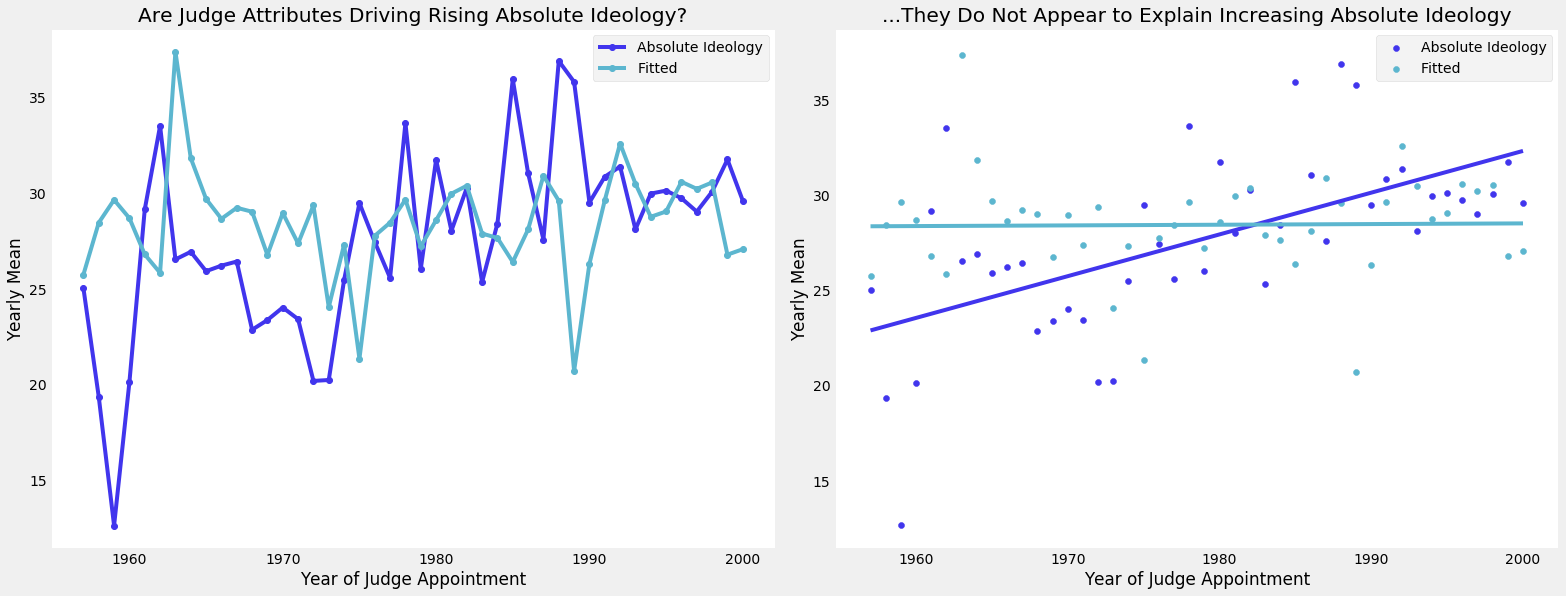

In [23]:
# Creating dataframe to ultimately generate mean observed, predicted, and residual values by year 
judges_decomposition = judges_ideology[["Year of Appointment","State","Absolute Ideology"]].copy()
judges_decomposition["Residuals"] = abs_ideo_resid
judges_decomposition["Fitted"] = abs_ideo_hat
year_decomposition =  judges_decomposition.groupby("Year of Appointment")[["Absolute Ideology","Residuals","Fitted"]].mean()
year_decomposition.reset_index(inplace = True)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,2,figsize=(22,8.5))

colors = ["#4135ed" ,"#5cb6cf"]
    
for counter,value in enumerate(["Absolute Ideology","Fitted"]):
    ax[0].plot(year_decomposition["Year of Appointment"],
                    year_decomposition[value],"-o", color = colors[counter],label=value)
    ax[1].scatter(year_decomposition["Year of Appointment"],
                    year_decomposition[value],  color = colors[counter],label=value)
    slope, intercept, r_value, p_value, std_err = stats.linregress(year_decomposition["Year of Appointment"],year_decomposition[value])
    line = slope*year_decomposition["Year of Appointment"]+intercept
    ax[1].plot(year_decomposition["Year of Appointment"], line,color=colors[counter],label="_")
      
ax[0].set_title("Are Judge Attributes Driving Rising Absolute Ideology?")   
ax[1].set_title("...They Do Not Appear to Explain Increasing Absolute Ideology")   

for n in [0,1]:
    ax[n].set_facecolor('white')
    ax[n].grid(False)
    ax[n].set_ylabel("Yearly Mean")
    ax[n].set_xlabel("Year of Judge Appointment")
    ax[n].legend()

fig.tight_layout()

The fitted values do not show an increase in predicted absolute ideology over time. But part of the reason is structural: we are controlling for year of appointment and other variables that vary over time such as appointed president. Next, we'll look at whether the judge's static _personal_ attributes (excluding age) predict the rise in absolute over time. We'll use the following variables: race, gender, previous job experience, judge's political party, and American Bar Association Rating (level of qualification).

First, we'll look at how judge personal attributes have changed over time. 

## Attributes Over Time

In [24]:
# Subset of full dataframe with only key judge personal attributes, as well as year of appointment
judges_personal = judges_ideology[["Age When Appointed","Race","Gender","Judge Party","Politician","ABA Rating","Year of Appointment"]]

# Manual "one-hot encoding" or in other words, creating columns which serve as indicator variables for key attributes
for race_name in ["White","African American"]:
    judges_personal[race_name] = [1 if race == race_name else 0 for race in judges_personal["Race"]]

judges_personal["Female"] = [1 if gender == "Female" else 0 for gender in judges_personal["Gender"]]
judges_personal["Republican"] = [1 if party == "Republican" else 0 for party in judges_personal["Judge Party"]]
judges_personal["Well Qualified"] = [1 if rating == "Well-Qual." else 0 for rating in judges_personal["ABA Rating"]]

mean_age = np.mean(judges["Age When Appointed"])
judges_personal["Young"] = [1 if age < mean_age else 0 for age in judges_personal["Age When Appointed"]]

judges_personal.head()

C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-v

Age When Appointed              Race Gender Judge Party  Politician  \
2                 55.0             White   Male  Republican           0   
3                 51.0             White   Male    Democrat           1   
4                 50.0             White   Male  Republican           0   
5                 57.0          Hispanic   Male  Republican           0   
10                48.0  African American   Male    Democrat           0   

    ABA Rating  Year of Appointment  White  African American  Female  \
2    Qualified                 1982      1                 0       0   
3   Well-Qual.                 1979      1                 0       0   
4   Well-Qual.                 1976      1                 0       0   
5    Qualified                 1982      0                 0       0   
10   Qualified                 1993      0                 1       0   

    Republican  Well Qualified  Young  
2            1               0      0  
3            0               1      0  
4            1               1      1  
5            1               0      0  
10           0               0      1

In [25]:
# Dataframe with the average fraction of judges with each personal attribute by year
year_personal = judges_personal.groupby("Year of Appointment")[["White","African American",
                                                               "Female","Republican","Well Qualified","Young"]].mean()

# Multiplying by 100 to provide percentage term interpretation 
for name in list(year_personal):
    year_personal[name] = 100*year_personal[name]
    
year_personal.head(n=15)  

White  African American    Female  Republican  \
Year of Appointment                                                       
1957                 100.000000          0.000000  0.000000  100.000000   
1958                 100.000000          0.000000  0.000000   90.909091   
1959                 100.000000          0.000000  0.000000   83.333333   
1960                 100.000000          0.000000  0.000000  100.000000   
1961                  95.081967          3.278689  0.000000    0.000000   
1962                 100.000000          0.000000  3.225806   29.032258   
1963                 100.000000          0.000000  0.000000    0.000000   
1964                  92.857143          7.142857  0.000000    0.000000   
1965                  94.736842          5.263158  0.000000    5.263158   
1966                  92.857143          4.761905  2.380952    7.142857   
1967                  86.666667          6.666667  0.000000    6.666667   
1968                 100.000000          0.000000  5.882353    5.882353   
1969                  78.571429         21.428571  0.000000  100.000000   
1970                  98.039216          0.000000  1.960784   98.039216   
1971                  96.428571          3.571429  0.000000   85.714286   

                     Well Qualified      Young  
Year of Appointment                             
1957                      46.153846  30.769231  
1958                      36.363636  27.272727  
1959                      50.000000  33.333333  
1960                      45.454545  54.545455  
1961                      47.540984  47.540984  
1962                      41.935484  29.032258  
1963                      66.666667  11.111111  
1964                      14.285714  64.285714  
1965                      52.631579  47.368421  
1966                      45.238095  47.619048  
1967                      43.333333  46.666667  
1968                      35.294118  41.176471  
1969                      28.571429  50.000000  
1970                      43.137255  60.784314  
1971                      50.000000  57.142857

This plot shows considerable variation over time in the proportion of judges with each of the personal attributes 

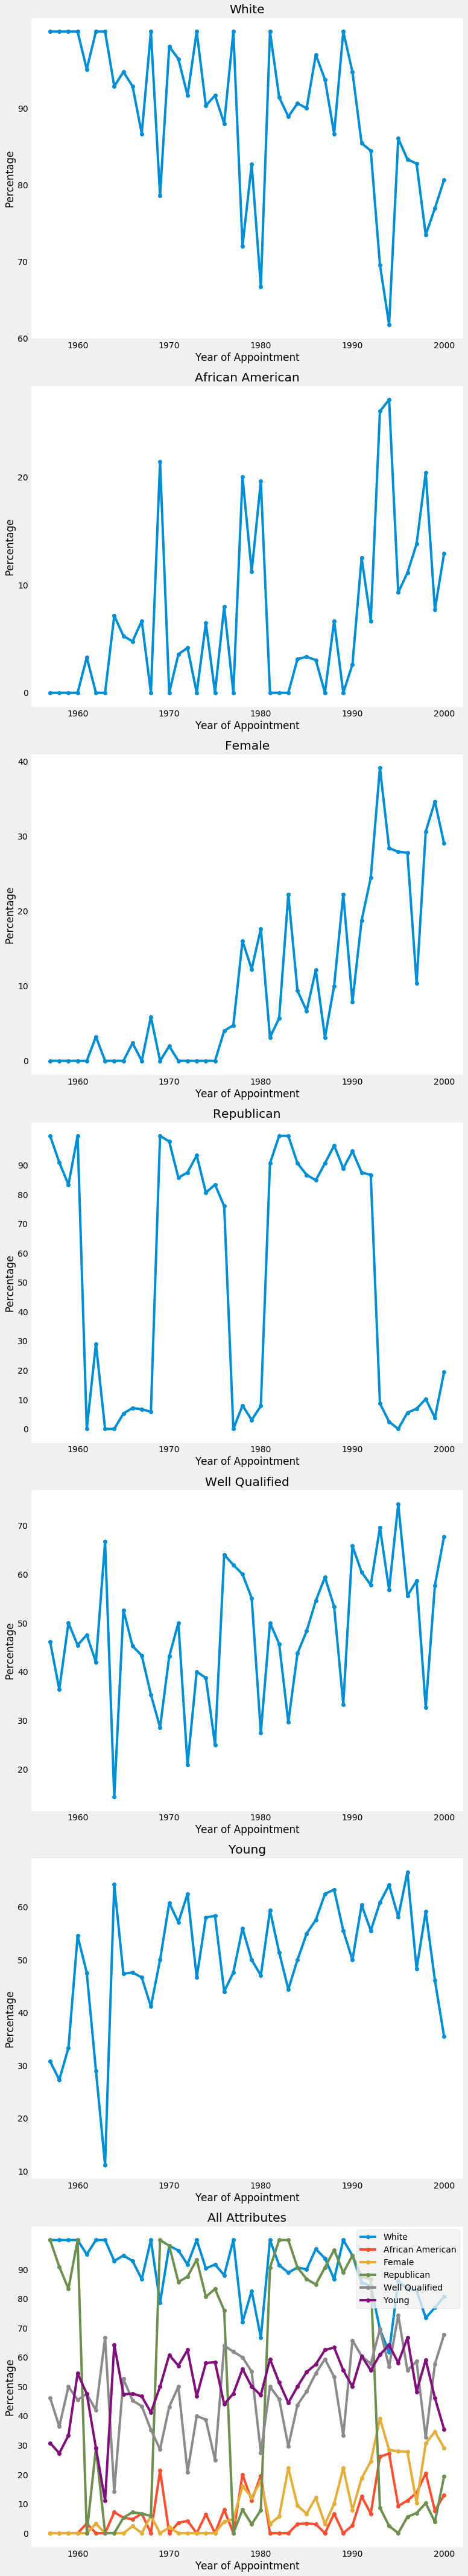

In [26]:
fig, ax = plt.subplots(7,1,figsize=(11,8.5*7))

for counter,attribute in enumerate(list(year_personal)):
    ax[counter].set_facecolor('white')
    ax[counter].grid(False)
    ax[counter].set_ylabel("Percentage")
    ax[counter].set_xlabel("Year of Appointment")
    ax[counter].set_yticks(range(0,100,10))
    ax[counter].plot(list(year_personal.index),year_personal[attribute],"-o",label=attribute)
    ax[counter].set_title(attribute)
    

# All the attributes in one plot (a bit overwhelming, but makes for comparison)
for attribute in list(year_personal):
    ax[6].set_facecolor('white')
    ax[6].grid(False)
    ax[6].set_ylabel("Percentage")
    ax[6].set_xlabel("Year of Appointment")
    ax[6].set_yticks(range(0,100,10))
    ax[6].plot(list(year_personal.index),year_personal[attribute],"-o",label=attribute)
    ax[6].set_title("All Attributes")
    ax[6].legend()
    
fig.tight_layout()

As the plot above shows, there variation in judge attributes over time. But do the changing attributes predict changing ideology?

Now we'll determine whether static personal attributes help explain rising judge absolute ideology.

## Static Attributes and Ideology

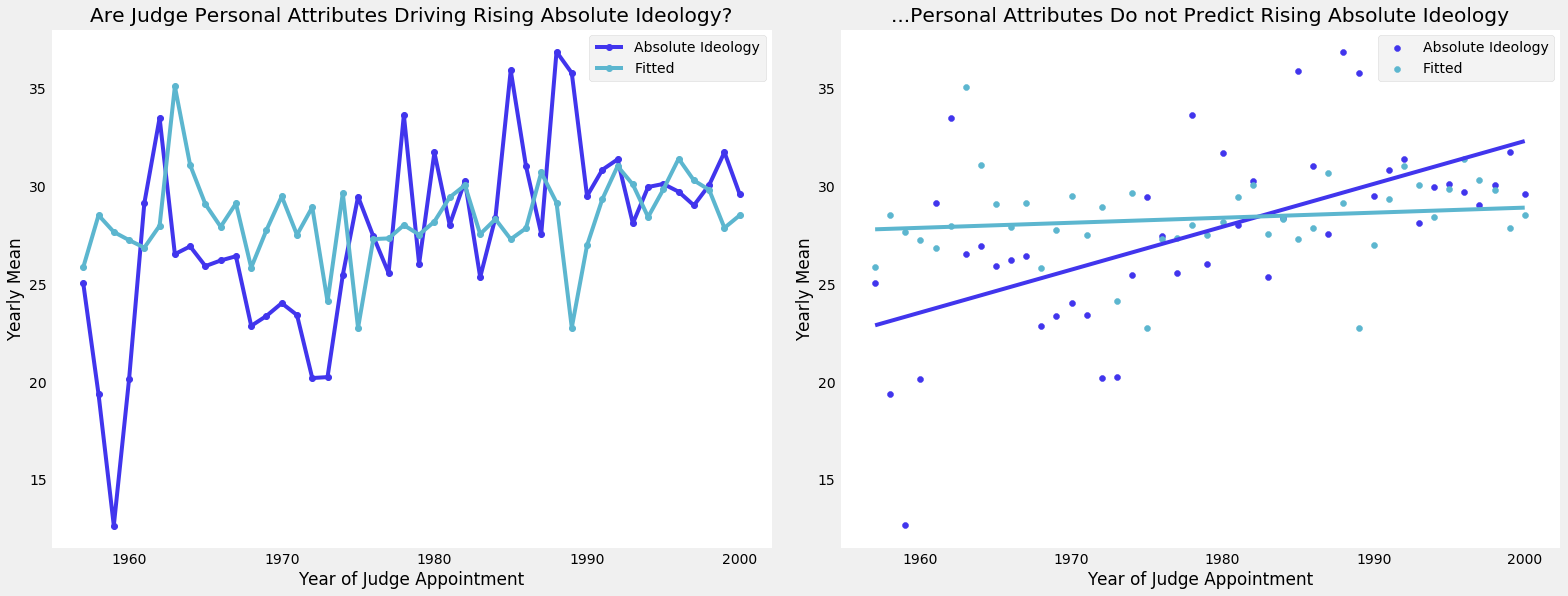

In [27]:
# We'll add "P" to the varialbe names to refer to "personal" and distinguish them from the variables above
continuous_variablesP = ['Age When Appointed', 'Previous Position - slc', 'Previous Position - locct', 
                         'Previous Position - sjdget', 'Previous Position - ausa', 'Previous Position - usa',
                         'Previous Position - sgo', 'Previous Position - sg', 'Previous Position - ago',
                         'Previous Position - ag', 'Previous Position - cc', 'Previous Position - sp', 
                         'Previous Position - mag', 'Previous Position - bank', 'Previous Position - terr',
                         'Previous Position - cab', 'Previous Position - asatty', 'Previous Position - satty',
                         'Previous Position - cabdept', 'Previous Position - scab', 'Previous Position - scabdpt',
                         'Previous Position - aag', 'Previous Position - indreg1', 'Previous Position - reg1',
                         'Previous Position - reg2', 'Previous Position - reg3', 'Previous Position - house',
                         'Previous Position - senate', 'Previous Position - gov', 'Previous Position - ssenate',
                         'Previous Position - shouse', 'Previous Position - mayor', 'Previous Position - ccoun',
                         'Previous Position - ccom', 'Previous Position - ada', 'Previous Position - da',
                         'Previous Position - lother', 'Previous Position - lotherl', 'Previous Position - lawprof',
                         'Previous Position - private']

# Categorical variables 
categoriesP = ['Judge Party','Gender','Race','ABA Rating']

# Using the fulldataset is equivalent to setting test_size = 0 
X_fullP, X_empty_test, abs_ideo_fullP, abs_ideo_empty_train = prep_data(
    judges_ideology,continuous_variablesP , categoriesP, "Absolute Ideology",test_size=0
)

# Fitted values
abs_ideo_hatP = forest_model.fit(X_fullP,abs_ideo_fullP).predict(X_fullP)

# Residuals
abs_ideo_residP = abs_ideo_fullP - abs_ideo_hatP

# Similar to above, creating dataframe with mean observed, residual and fitted values by year
judges_decompositionP = judges_ideology[["Year of Appointment","State","Absolute Ideology"]].copy()
judges_decompositionP["Residuals"] = abs_ideo_residP
judges_decompositionP["Fitted"] = abs_ideo_hatP
year_decompositionP = judges_decompositionP.groupby("Year of Appointment")[["Absolute Ideology","Residuals","Fitted"]].mean()
year_decompositionP.reset_index(inplace = True)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,2,figsize=(22,8.5))
colors = ["#4135ed" ,"#5cb6cf"]

# Plotting trends in observed and fitted values
for counter,value in enumerate(["Absolute Ideology","Fitted"]):
    ax[0].plot(year_decompositionP["Year of Appointment"],
                    year_decompositionP[value],"-o", color = colors[counter],label=value)
    ax[1].scatter(year_decompositionP["Year of Appointment"],
                    year_decompositionP[value],  color = colors[counter],label=value)
    slope, intercept, r_value, p_value, std_err = stats.linregress(year_decompositionP["Year of Appointment"],year_decompositionP[value])
    line = slope*year_decompositionP["Year of Appointment"]+intercept
    ax[1].plot(year_decompositionP["Year of Appointment"], line,color=colors[counter],label="_")
      
ax[0].set_title("Are Judge Personal Attributes Driving Rising Absolute Ideology?")   
ax[1].set_title("...Personal Attributes Do not Predict Rising Absolute Ideology")
for n in [0,1]:
    ax[n].set_facecolor('white')
    ax[n].grid(False)
    ax[n].set_ylabel("Yearly Mean")
    ax[n].set_xlabel("Year of Judge Appointment")
    ax[n].legend()
    #ax[n].set_yticks(range(0,40,5))

fig.tight_layout()

The meaning behind this chart is that the shifting of judges' static personal attributes over time does not explain the rise in absolute ideology. It is interest how similar this chart is to the the chart above, which included dynamic attributes of judges (including year of appointment, appointing president, etc.). The chart may beg the question: how much does adding dynamic attributes really improve the predictive power of the random forest model? Comparing the the MSE's of the random forest model with and without dynamic attributes (see below), it is clear the dynamic attributes do add predictive power. That said, the charts, taken together, suggest there are unobserved forces behind the rising absolute ideology of US judges

In [28]:
# All judge attributes
full_mse = metrics.mean_squared_error(abs_ideo_full,
                                      forest_model.fit(X_full,abs_ideo_full).predict(X_full))


# Only including static personal attributes
full_mseP = metrics.mean_squared_error(abs_ideo_fullP,
                                      forest_model.fit(X_fullP,abs_ideo_fullP).predict(X_fullP))

print(f"MSE with all Attributes: {full_mse}")
print(f"MSE with only Static Personal Attributes: {full_mseP}")

MSE with all Attributes: 10.762745067579159
MSE with only Static Personal Attributes: 53.242898266036356


# Part 4 - Estimating Nuisance Function

We'll estimate the influence of judge political experience on judge ideology

Are judges with past experience as elected officials more ideological?

We'll estimate regressions of the form 

$$Y = \beta Politician + f(x) + \epsilon $$

where $Y$ is ideology or absolute ideology, $Politician$ is an indicator for past politican experience, and $f(x)$ is the nuisance function for the controls (judge attributes) 

## Preparing Data

In [29]:
# Creating a dataframe which is ready for regressions/partial regressions

# Setting continuous variables for this analysis (the categories are the same as the ones above)

continuous_variables2 = ["Ideology Score","Absolute Ideology","Politician",
                          'Previous Position - house', 'Previous Position - senate',
                         'Previous Position - gov','Previous Position - ssenate',
                         'Previous Position - shouse','Previous Position - mayor',
                         'Previous Position - ccoun','House Democrats','House Republicans',
                        'Senate Democrats', 'Senate Republicans','House Independents','Senate Independents']

political_judges = judges_ideology[continuous_variables2]
political_judges.reset_index(inplace = True)
political_judges = political_judges.drop(["index"],axis=1)
political_judges.head()

Ideology Score  Absolute Ideology  Politician  Previous Position - house  \
0       40.700001          40.700001           0                          0   
1      -30.599999          30.599999           1                          1   
2        6.100000           6.100000           0                          0   
3       53.799999          53.799999           0                          0   
4      -22.600000          22.600000           0                          0   

   Previous Position - senate  Previous Position - gov  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   Previous Position - ssenate  Previous Position - shouse  \
0                            0                           0   
1                            0                           0   
2                            0                           0   
3                            0                           0   
4                            0                           0   

   Previous Position - mayor  Previous Position - ccoun  House Democrats  \
0                          0                          0              243   
1                          0                          0              277   
2                          0                          0              291   
3                          0                          0              243   
4                          0                          0              258   

   House Republicans  Senate Democrats  Senate Republicans  \
0                192                47                  53   
1                158                59                  41   
2                144                61                  38   
3                192                47                  53   
4                176                57                  43   

   House Independents  Senate Independents  
0                   0                    0  
1                   0                    0  
2                   0                    0  
3                   0                    0  
4                   1                    0

In [30]:
#Creating indicator variables for all categorical variables

ohe = preprocessing.OneHotEncoder(sparse=False)


#OneHotEncoder creates a numpy array which we have to convert to a dataframe. 
political_judges_dummies = pd.DataFrame.from_records(ohe.fit_transform(judges_ideology[categories]))

#From the array, we have no meaningful variable/column names.
#Nonetheless, we are not particularly interested in which of these indicator variables
#have predictive power, so we'll just name them numerically
dummy_columns = ["dummy" + str(i) for i in range(654)]

political_judges_dummies.columns = dummy_columns
political_judges_dummies.head(n=10)

dummy0  dummy1  dummy2  dummy3  dummy4  dummy5  dummy6  dummy7  dummy8  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
8     0.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0   
9     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   dummy9    ...     dummy644  dummy645  dummy646  dummy647  dummy648  \
0     0.0    ...          0.0       0.0       0.0       0.0       1.0   
1     0.0    ...          0.0       0.0       0.0       0.0       1.0   
2     0.0    ...          0.0       0.0       0.0       0.0       1.0   
3     0.0    ...          0.0       0.0       1.0       0.0       0.0   
4     0.0    ...          1.0       0.0       0.0       0.0       0.0   
5     0.0    ...          0.0       0.0       0.0       0.0       1.0   
6     0.0    ...          0.0       0.0       1.0       0.0       0.0   
7     0.0    ...          0.0       0.0       0.0       0.0       1.0   
8     0.0    ...          0.0       0.0       0.0       0.0       1.0   
9     0.0    ...          0.0       0.0       0.0       0.0       1.0   

   dummy649  dummy650  dummy651  dummy652  dummy653  
0       0.0       0.0       0.0       1.0       0.0  
1       0.0       0.0       0.0       0.0       1.0  
2       0.0       0.0       0.0       0.0       1.0  
3       0.0       0.0       0.0       1.0       0.0  
4       0.0       0.0       0.0       1.0       0.0  
5       0.0       0.0       0.0       1.0       0.0  
6       0.0       0.0       0.0       1.0       0.0  
7       0.0       0.0       0.0       1.0       0.0  
8       0.0       0.0       0.0       0.0       1.0  
9       0.0       0.0       0.0       1.0       0.0  

[10 rows x 654 columns]

In [31]:
#Combining the dataframes with the continuous and indicator variables
political_judges = pd.concat([political_judges, political_judges_dummies],axis=1)
political_judges.head()

Ideology Score  Absolute Ideology  Politician  Previous Position - house  \
0       40.700001          40.700001           0                          0   
1      -30.599999          30.599999           1                          1   
2        6.100000           6.100000           0                          0   
3       53.799999          53.799999           0                          0   
4      -22.600000          22.600000           0                          0   

   Previous Position - senate  Previous Position - gov  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   Previous Position - ssenate  Previous Position - shouse  \
0                            0                           0   
1                            0                           0   
2                            0                           0   
3                            0                           0   
4                            0                           0   

   Previous Position - mayor  Previous Position - ccoun    ...     dummy644  \
0                          0                          0    ...          0.0   
1                          0                          0    ...          0.0   
2                          0                          0    ...          0.0   
3                          0                          0    ...          0.0   
4                          0                          0    ...          1.0   

   dummy645  dummy646  dummy647  dummy648  dummy649  dummy650  dummy651  \
0       0.0       0.0       0.0       1.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       1.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       1.0       0.0       0.0       0.0   
3       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   dummy652  dummy653  
0       1.0       0.0  
1       0.0       1.0  
2       0.0       1.0  
3       1.0       0.0  
4       1.0       0.0  

[5 rows x 670 columns]

## OLS 

First, we'll run the OLS regression. We have hundreds of dummy variables, and including them manually in the regression would be tedious.

In [32]:
def list_to_formula(var_list):
    """ 
    Given a list of variable names: var1, var2, ... varN,
    Output single string: + var1 + var2 + ... + varN
    """
    output = ""
    for var in var_list:
        output = output + " + " + var
    return output

To include variables with spaces in their name in the regression, we need to rely on patsy and put them in the form Q('variable name')

In [33]:
congress_composition = ['House Democrats','House Republicans','Senate Democrats',
                        'Senate Republicans','House Independents','Senate Independents',]

congress_composition_Q = ["Q('" + val + "')" for val in congress_composition]

composition_formula = list_to_formula(congress_composition_Q)

# We'll also make a formula for the dummy variables
dummies_formula = list_to_formula(dummy_columns)

# Estimating three variations of the model (adding controls)
lm_ideo = list()
lm_ideo.append(smf.ols(formula="Q('Ideology Score') ~ Politician", data=political_judges,
                  missing="drop").fit(cov_type='HC0'))

lm_ideo.append(smf.ols(formula="Q('Ideology Score') ~ Politician" + composition_formula
                  ,data=political_judges,
                  missing="drop").fit(cov_type='HC0'))

lm_ideo.append(smf.ols(formula="Q('Ideology Score') ~ Politician" + composition_formula + dummies_formula
                  ,data=political_judges,
                  missing="drop").fit(cov_type='HC0'))


# Notably, the inclusion of the dummies (important controls) flipped the sign of the Politician coefficient! 
summary_col(lm_ideo, stars=True)

C:\Users\Ian\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\Ian\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in greater

C:\Users\Ian\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in less

C:\Users\Ian\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning:

invalid value encountered in less_equal



<class 'statsmodels.iolib.summary2.Summary'>
"""

=============================================================================================
                         Q('Ideology Score') I Q('Ideology Score') II Q('Ideology Score') III
---------------------------------------------------------------------------------------------
Intercept                -1.5510*              1104.0585***           0.2721                 
                         (0.9003)              (97.9475)              (0.2390)               
Politician               -1.7957               -1.2555                1.7023                 
                         (2.6717)              (2.3194)               (1.3807)               
Q('House Democrats')                           -0.6835***             0.1280                 
                                               (0.0965)               (0.1688)               
Q('House Independents')                        -19.0197***            1.6115                 
                                               (2.0924)               (1.7263)               
Q('House Republicans')                         -1.1714***             0.0014                 
                                               (0.1111)               (0.1310)               
Q('Senate Democrats')                          -8.3880***             -0.4918                
                                               (0.8194)               (0.7375)               
Q('Senate Independents')                       0.0000                 -0.0000***             
                                               (0.0000)               (0.0000)               
Q('Senate Republicans')                        -5.6559***             -0.1453                
                                               (0.8063)               (0.6026)               
dummy0                                                                8.7967**               
                                                                      (3.7420)               
dummy1                                                                -0.0369                
                                                                      (3.8463)               
dummy10                                                               -1.1470                
                                                                      (4.2688)               
dummy100                                                              -4.6980*               
                                                                      (2.7500)               
dummy101                                                              -1.9303                
                                                                      (3.1707)               
dummy102                                                              -5.7876*               
                                                                      (3.0750)               
dummy103                                                              2.3233                 
                                                                      (3.5053)               
dummy104                                                              -3.3165                
                                                                      (4.0422)               
dummy105                                                              17.5145**              
                                                                      (6.8378)               
dummy106                                                              -0.9921                
                                                                      (9.5944)               
dummy107                                                              1.9969                 
                                                                      (11.7381)              
dummy108                                                              10.4009                
  

Repeating with absolute ideology as the outcome

In [34]:
lm_asb_ideo = list()
lm_asb_ideo.append(smf.ols(formula="Q('Absolute Ideology') ~ Politician", data=political_judges,
                  missing="drop").fit(cov_type='HC0'))

lm_asb_ideo.append(smf.ols(formula="Q('Absolute Ideology') ~ Politician" + composition_formula
                  ,data=political_judges,
                  missing="drop").fit(cov_type='HC0'))

lm_asb_ideo.append(smf.ols(formula="Q('Absolute Ideology') ~ Politician" + composition_formula + dummies_formula
                  ,data=political_judges,
                  missing="drop").fit(cov_type='HC0'))

# Inclusion of the full set of dummies flipped the sign of the Politician coefficient, again
summary_col(lm_asb_ideo, stars=True)

<class 'statsmodels.iolib.summary2.Summary'>
"""

======================================================================================================
                         Q('Absolute Ideology') I Q('Absolute Ideology') II Q('Absolute Ideology') III
------------------------------------------------------------------------------------------------------
Intercept                28.5407***               -272.0906***              -0.3419*                  
                         (0.4117)                 (64.0601)                 (0.1971)                  
Politician               -1.8292                  -0.6761                   0.3298                    
                         (1.3808)                 (1.4009)                  (1.5538)                  
Q('House Democrats')                              0.1698***                 -0.0750                   
                                                  (0.0627)                  (0.1381)                  
Q('House Independents')                           1.8830*                   1.4025                    
                                                  (0.9781)                  (1.7199)                  
Q('House Republicans')                            0.1181*                   -0.0537                   
                                                  (0.0674)                  (0.1129)                  
Q('Senate Democrats')                             2.2413***                 0.6618                    
                                                  (0.5456)                  (0.6099)                  
Q('Senate Independents')                          0.0000                    -0.0000***                
                                                  (0.0000)                  (0.0000)                  
Q('Senate Republicans')                           2.5066***                 0.5657                    
                                                  (0.5423)                  (0.5132)                  
dummy0                                                                      -6.4309*                  
                                                                            (3.5146)                  
dummy1                                                                      2.2893                    
                                                                            (3.9393)                  
dummy10                                                                     4.7159                    
                                                                            (4.5786)                  
dummy100                                                                    0.9001                    
                                                                            (3.0147)                  
dummy101                                                                    1.7881                    
                                                                            (3.1954)                  
dummy102                                                                    4.2295                    
                                                                            (3.1828)                  
dummy103                                                                    1.3625                    
                                                                            (3.2565)                  
dummy104                                                                    -6.1599                   
                                                                            (4.9198)                  
dummy105                                                                    1.3123                    
                                                                            (7.3208)                  
dummy106                                                                    -0.1749                   
                                    

## Partial Linear Regression With Lasso

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may

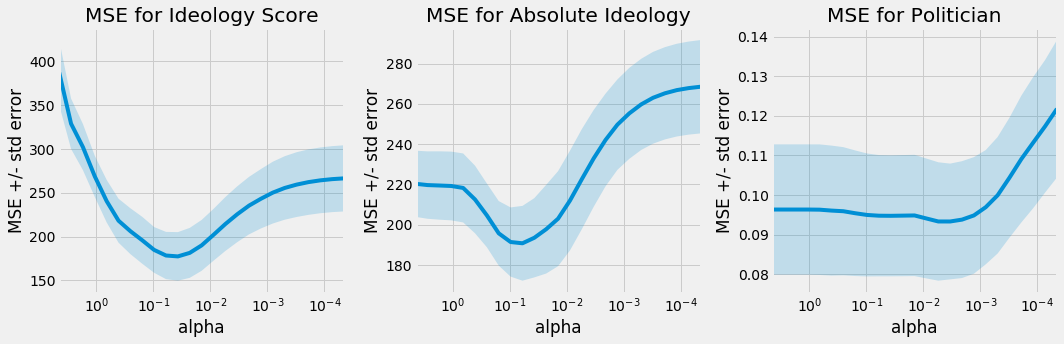

In [35]:
def partial_linear(y, d, X, yestimator, destimator, folds=3):
    """Estimate the partially linear model y = d*C + f(x) + e

    Parameters
    ----------
    y : array_like
        vector of outcomes
    d : array_like
        vector or matrix of regressors of interest
    X : array_like
        matrix of controls
    mlestimate : Estimator object for partialling out X. Must have ‘fit’
        and ‘predict’ methods.
    folds : int
        Number of folds for cross-fitting

    Returns
    -------
    ols : statsmodels regression results containing estimate of coefficient on d.
    yhat : cross-fitted predictions of y
    dhat : cross-fitted predictions of d
    """

    # we want predicted probabilities if y or d is discrete
    ymethod = "predict" if False==getattr(yestimator, "predict_proba",False) else "predict_proba"
    dmethod = "predict" if False==getattr(destimator, "predict_proba",False) else "predict_proba"
    # get the predictions
    yhat = cross_val_predict(yestimator,X,y,cv=folds,method=ymethod)
    dhat = cross_val_predict(destimator,X,d,cv=folds,method=dmethod)
    ey = np.array(y - yhat)
    ed = np.array(d - dhat)
    ols = sm.regression.linear_model.OLS(ey,ed).fit(cov_type='HC0')

    return(ols, yhat, dhat)

# Prepare data
formula="Q('Ideology Score') + Q('Absolute Ideology') + Politician ~ " + composition_formula + dummies_formula

yd, X = dmatrices(formula,political_judges)
ideo = yd[:,0]
abs_ideo = yd[:,1]
politician = yd[:,2]

# We use another list of alphas compared to the above, so this is number 2
alphas2 = np.exp(np.linspace(1.5, -10., 25))
lasso_ideo = linear_model.LassoCV(cv=6, alphas=alphas2, max_iter=500).fit(X,ideo)
lasso_abs_ideo = linear_model.LassoCV(cv=6, alphas=alphas2, max_iter=500).fit(X,abs_ideo)
lasso_politician = linear_model.LassoCV(cv=6, alphas=alphas2, max_iter=500).fit(X,politician)

fig, ax = plt.subplots(1,3, figsize=(15,5))

# Plotting the MSE for the two outcomes and the explanatory variable, "Politician"
def plotlassocv(l, ax) :
    alphas = l.alphas_
    mse = l.mse_path_.mean(axis=1)
    std_error = l.mse_path_.std(axis=1)
    ax.plot(alphas,mse)
    ax.fill_between(alphas, mse + std_error, mse - std_error, alpha=0.2)

    ax.set_ylabel('MSE +/- std error')
    ax.set_xlabel('alpha')
    ax.set_xlim([alphas[0], alphas[-1]])
    ax.set_xscale("log")
    return(ax)
   
ax[0] = plotlassocv(lasso_ideo,ax[0])
ax[0].set_title("MSE for Ideology Score")
ax[1] = plotlassocv(lasso_abs_ideo,ax[1])
ax[1].set_title("MSE for Absolute Ideology")
ax[2] = plotlassocv(lasso_politician,ax[2])
ax[2].set_title("MSE for Politician")

fig.tight_layout()

In [36]:
# Summarizing the lasso model partial regression
pl_lasso_ideo = partial_linear(ideo, politician, X,
                          linear_model.Lasso(alpha=lasso_ideo.alpha_),
                          linear_model.Lasso(alpha=lasso_politician.alpha_))
pl_lasso_ideo[0].summary()

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.02221
Date:                Sun, 21 Apr 2019   Prob (F-statistic):              0.882
Time:                        18:35:11   Log-Likelihood:                -5708.4
No. Observations:                1420   AIC:                         1.142e+04
Df Residuals:                    1419   BIC:                         1.142e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1924      1.291      0.149      0.882      -2.338       2.723
==============================================================================
Omnibus:                       45.691   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.136
Skew:                           0.056   Prob(JB):                     9.97e-26
Kurtosis:                       4.390   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [37]:
# Now for absolute ideology
pl_lasso_abs_ideo = partial_linear(abs_ideo, politician, X,
                          linear_model.Lasso(alpha=lasso_abs_ideo.alpha_),
                          linear_model.Lasso(alpha=lasso_politician.alpha_))
pl_lasso_abs_ideo[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5756
Date:                Sun, 21 Apr 2019   Prob (F-statistic):              0.448
Time:                        18:35:13   Log-Likelihood:                -5762.4
No. Observations:                1420   AIC:                         1.153e+04
Df Residuals:                    1419   BIC:                         1.153e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.0393      1.370     -0.759      0.448      -3.724       1.646
==============================================================================
Omnibus:                       31.882   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.034
Skew:                           0.085   Prob(JB):                     0.000121
Kurtosis:                       2.475   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

## Partial Linear Regression with Random Forests

In [38]:
# Fitting the forest model
forest_ideo = RandomForestRegressor(n_estimators = 100).fit(X,ideo)
forest_abs_ideo = RandomForestRegressor(n_estimators = 100).fit(X,abs_ideo)
fores_politician = RandomForestRegressor(n_estimators = 100).fit(X,politician)

# Summarizing the partial linear regression with Random Forests
pl_forest_ideo = partial_linear(ideo, politician, X,
                          RandomForestRegressor(n_estimators = 100),
                          RandomForestRegressor(n_estimators = 100))
pl_lasso_ideo[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.02221
Date:                Sun, 21 Apr 2019   Prob (F-statistic):              0.882
Time:                        18:35:57   Log-Likelihood:                -5708.4
No. Observations:                1420   AIC:                         1.142e+04
Df Residuals:                    1419   BIC:                         1.142e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1924      1.291      0.149      0.882      -2.338       2.723
==============================================================================
Omnibus:                       45.691   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.136
Skew:                           0.056   Prob(JB):                     9.97e-26
Kurtosis:                       4.390   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [39]:
# Absolute ideology
pl_forest_abs_ideo = partial_linear(abs_ideo, politician, X,
                          RandomForestRegressor(n_estimators = 100),
                          RandomForestRegressor(n_estimators = 100))
pl_forest_abs_ideo[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.06898
Date:                Sun, 21 Apr 2019   Prob (F-statistic):              0.793
Time:                        18:36:22   Log-Likelihood:                -5252.3
No. Observations:                1420   AIC:                         1.051e+04
Df Residuals:                    1419   BIC:                         1.051e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2503      0.953     -0.263      0.793      -2.118       1.618
==============================================================================
Omnibus:                       52.141   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.897
Skew:                          -0.108   Prob(JB):                     3.09e-30
Kurtosis:                       4.500   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

## Partial Linear Regression with Neural Networks

In [40]:
#Summarizing the neural network model's partial linear regression
pl_nn_ideo = partial_linear(ideo, politician, X,
                          nn_scaled_model, #from above
                          nn_scaled_model)

pl_nn_ideo[0].summary()

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.009375
Date:                Sun, 21 Apr 2019   Prob (F-statistic):              0.923
Time:                        18:37:15   Log-Likelihood:                -5852.5
No. Observations:                1420   AIC:                         1.171e+04
Df Residuals:                    1419   BIC:                         1.171e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1078      1.113     -0.097      0.923      -2.290       2.074
==============================================================================
Omnibus:                      108.136   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              422.939
Skew:                          -0.263   Prob(JB):                     1.45e-92
Kurtosis:                       5.621   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [41]:
pl_nn_abs_ideo = partial_linear(abs_ideo, politician, X,
                          nn_scaled_model,
                          nn_scaled_model)

pl_nn_abs_ideo[0].summary()

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.219
Date:                Sun, 21 Apr 2019   Prob (F-statistic):              0.270
Time:                        18:38:10   Log-Likelihood:                -5843.2
No. Observations:                1420   AIC:                         1.169e+04
Df Residuals:                    1419   BIC:                         1.169e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.1489      1.041     -1.104      0.270      -3.189       0.891
==============================================================================
Omnibus:                       12.113   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.104
Skew:                           0.175   Prob(JB):                      0.00143
Kurtosis:                       3.315   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

## Summary of Partial Linear Models 

In [42]:
print("Outcome: Ideology (positive = conservative)")
summary_col([pl_lasso_ideo[0], pl_forest_ideo[0],pl_nn_ideo[0]],
            model_names=["Lasso", "Random Forest","Neural Network"] ,stars=False)

Outcome: Ideology (positive = conservative)


<class 'statsmodels.iolib.summary2.Summary'>
"""

========================================
    Lasso   Random Forest Neural Network
----------------------------------------
x1 0.1924   -0.6276       -0.1078       
   (1.2910) (0.9753)      (1.1133)      
========================================
Standard errors in parentheses.
"""

In [43]:
print("Outcome: Absolute Ideology")
summary_col([pl_lasso_abs_ideo[0], pl_forest_abs_ideo[0], pl_nn_abs_ideo[0]],
            model_names=["Lasso", "Random Forest","Neural Network"],stars=False)

Outcome: Absolute Ideology


<class 'statsmodels.iolib.summary2.Summary'>
"""

========================================
    Lasso   Random Forest Neural Network
----------------------------------------
x1 -1.0393  -0.2503       -1.1489       
   (1.3698) (0.9531)      (1.0408)      
========================================
Standard errors in parentheses.
"""

Overall, due to the imprecise (and somewhat noisy estimates across methods), we don't have evidence that past political experience is highly correlated with either ideology or absolute ideology. For absolute ideology, there is suggestive evidence that past political experience is correlated with more ideologically centrist judges (lower absolute ideology). The story for raw ideology as the outcome is less clear, as the coefficients have different signs across methods.

# Part 5 - Overview of Judge Decision Making

We now turn to our final dataset, which contains every decision made by US Federal District Courts that can be categorized as political - over 100000 in total. We begin by showing key characteristics of the data.

## Data Overview

In [44]:
# We only need some of this data
judge_decisions = decision_data[['Authoring Judge','Court Location','Number of Judges','Circuit','Year','Decision Ideology',
                                'Case Type','Case Category','Year of Appointment','Appointing President','Judge Party',
                                'Gender','Race','Year of Birth','ABA Rating','Congress','Unity']].copy()

# We begin by converting the decision ideology, which is either liberal or conservative, into a dummy.
def libcon_dummy(ideology):
    if ideology == 'Conservative':
        return 100
    if ideology == 'Liberal':
        return -100
    else:
        return np.nan
judge_decisions['Decision Ideology'] = judge_decisions['Decision Ideology'].apply(libcon_dummy)

# Here is what the data looks like
judge_decisions.head()

Authoring Judge    Court Location  Number of Judges      Circuit  Year  \
0    Avis, John Boyd        Camden, NJ                 1  3RD CIRCUIT  1932   
1    Avis, John Boyd        Camden, NJ                 1  3RD CIRCUIT  1932   
2    Strum, Louie W.  Jacksonville, FL                 1  5TH CIRCUIT  1932   
3  Moscowitz, Grover      Brooklyn, NY                 5  2ND CIRCUIT  1932   
4    Cochran, Andrew     Maysville, KY                 1  6TH CIRCUIT  1932   

   Decision Ideology                Case Type                 Case Category  \
0                100          alien petitions  Civil Liberties/Rights Cases   
1                100          alien petitions  Civil Liberties/Rights Cases   
2                100  (non)conv-criminal case        Criminal Justice Cases   
3                100   criminal court motions        Criminal Justice Cases   
4               -100            voting rights  Civil Liberties/Rights Cases   

   Year of Appointment Appointing President Judge Party Gender  \
0                 1929               HOOVER  Republican   male   
1                 1929               HOOVER  Republican   male   
2                 1931               HOOVER    Democrat   male   
3                 1925             COOLIDGE  Republican   male   
4                 1901             MCKINLEY  Republican   male   

              Race  Year of Birth ABA Rating Congress           Unity  
0  white/caucasian         1875.0  Not Rated     78TH         Unified  
1  white/caucasian         1875.0  Not Rated     78TH         Unified  
2  white/caucasian         1890.0  Not Rated     81ST  Divided, House  
3  white/caucasian         1886.0  Not Rated     80TH         Unified  
4  white/caucasian         1854.0  Not Rated     73RD         Unified

First, we plot the average decision ideology by case type.

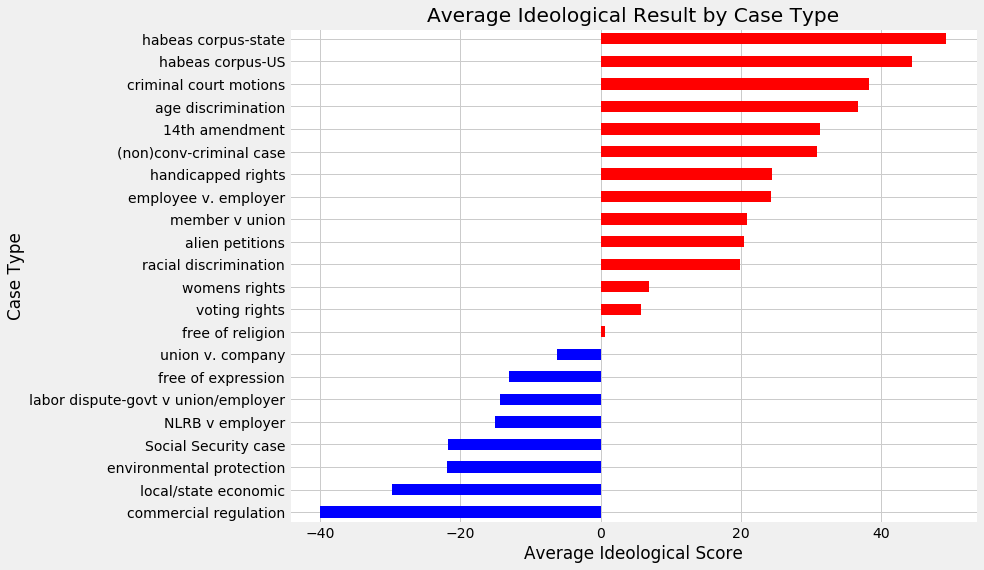

In [45]:
# Get the list of case types with more than 1000 cases
high_vol_types = judge_decisions[['Case Type','Authoring Judge']].groupby('Case Type').count().reset_index()
high_vol_types['High Vol'] = [1 if count >= 1000 else 0 for count in high_vol_types['Authoring Judge']]
high_vol_types = high_vol_types[high_vol_types['High Vol'] == 1]
high_vol_types = high_vol_types.drop(columns = ['Authoring Judge','High Vol'])

ideology_by_type = (judge_decisions[['Case Type','Decision Ideology']].groupby('Case Type')
                    .mean().sort_values('Decision Ideology').reset_index())
ideology_by_type = ideology_by_type.merge(high_vol_types, on = 'Case Type', how = 'right')

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(11,8.5))
ax.set_facecolor('white')
ax.grid(False)
ax.set_title("Average Ideological Result by Case Type")
ax.set_xlabel("Average Ideological Score")
colors = ["b" if x < 0 else "r" for x in ideology_by_type['Decision Ideology'].values]

ideology_by_type.plot(kind = 'barh', x = 'Case Type', y = 'Decision Ideology', ax = ax, color = colors, legend = False)

Nothing too crazy is happening here - certain types seem to be prone to a certain ideological result, but everything seems balanced overall. Next, we explore how the results have changed over time, and how they depend on judge ideology.

Text(0, 0.5, 'Mean Decision Ideology Score')

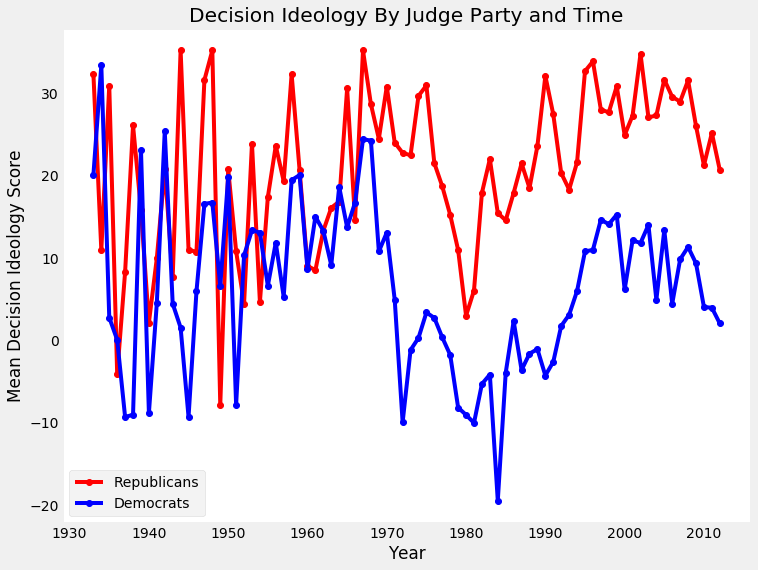

In [46]:
ideology_by_party_year = (judge_decisions[['Year','Judge Party','Decision Ideology']].groupby(['Year','Judge Party',])
                          .mean().reset_index())
ideology_by_party_year = ideology_by_party_year[(ideology_by_party_year['Judge Party'] == 'Democrat') |
                                                (ideology_by_party_year['Judge Party'] == 'Republican')]
# 1933 is first year where both parties are present
ideology_by_party_year = ideology_by_party_year[ideology_by_party_year['Year'] >= 1933]
democrats = ideology_by_party_year["Judge Party"] == "Democrat"
republicans = ideology_by_party_year["Judge Party"] == "Republican"

fig, ax = plt.subplots(figsize=(11,8.5))
ax.set_facecolor('white')
ax.grid(False)

ax.plot(ideology_by_party_year[republicans]["Year"],
        ideology_by_party_year[republicans]["Decision Ideology"],"-o",label="Republicans",color='r')

ax.plot(ideology_by_party_year[democrats]["Year"],
        ideology_by_party_year[democrats]["Decision Ideology"],"-o",label="Democrats",color='b')

ax.legend()
ax.set_title("Decision Ideology By Judge Party and Time")
ax.set_xlabel("Year")
ax.set_ylabel("Mean Decision Ideology Score")

Between 1930 and 1970, Democratic and Republican judges were practically indistinguishable! But since 1970, there has been a sharp divide, with judges sticking to their ideology more consistently. However, a similar trend appears for both parties. Overall, results seem to generally be more conservative. Since presidents appoint these judges, it is interesting to ask how results vary by appointing president. Could this be why things have changed since 1970?

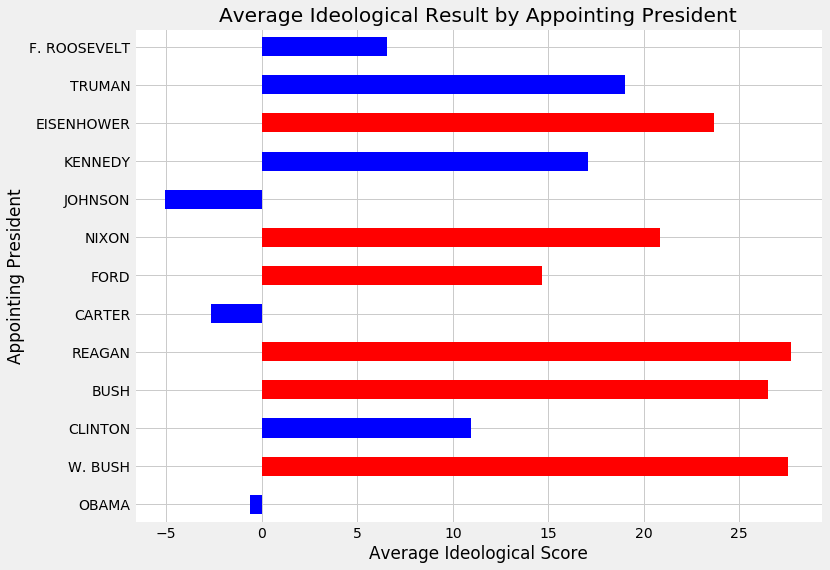

In [47]:
ideology_by_app_pres = (judge_decisions[judge_decisions['Year of Appointment']>=1933]
                        [['Appointing President','Decision Ideology']]
                        .groupby(['Appointing President'])
                        .mean().reset_index().reindex([9,12,2,0,10,1,5,8,6,7,3,11,4]))
fig, ax = plt.subplots(figsize=(11,8.5))
ax.set_facecolor('white')
ax.grid(False)
ax.set_title("Average Ideological Result by Appointing President")
ax.set_xlabel("Average Ideological Score")
colors = ["b" if x in ['F. ROOSEVELT','TRUMAN','KENNEDY','JOHNSON','CARTER','CLINTON','OBAMA'] 
          else "r" for x in ideology_by_app_pres['Appointing President'].values]

ideology_by_app_pres.plot(kind = 'barh', x = 'Appointing President', y = 'Decision Ideology',
                          ax = ax, color = colors, legend = False)

This seems to explain some of the results! Roosevelt, Truman and Kennedy's Judges voted more conservative despite being appointed by a Democrat! Judges have generally stuck to their appointing president's ideology since then. What if, however, party and president have nothing to do with these decisions? Could personal attributes of judges drive their decision-making?

In [48]:
ideology_by_gen_race = (judge_decisions[judge_decisions['Race'].isin(
                                        ['African-American/black','Asian-American','Latino/Hispanic','white/caucasian'])]
                       .pivot_table(index='Race', columns='Gender', values='Decision Ideology', margins=True))
ideology_by_gen_race

Gender                     female       male        All
Race                                                   
African-American/black   1.870748   5.016212   4.439944
Asian-American         -14.754098   5.413105   0.211416
Latino/Hispanic          5.091650  26.355388  24.271457
white/caucasian         12.628256  15.822735  15.497959
All                     10.976939  15.695166  15.190996

This seems to be the case! Overall, male judges vote more conservatively than female judges. Meanwhile, Afrian-American and Asian-American judges are more liberal than the rest. However, when comparing the overall mean to the mean for white male judges, we realize that these are practically the same. The majority of judges are indeed white men - so while this might explain some individual nuances, it can't be driving the large divergence. Finally, we ask: could this be due to differences in the quality of judges?

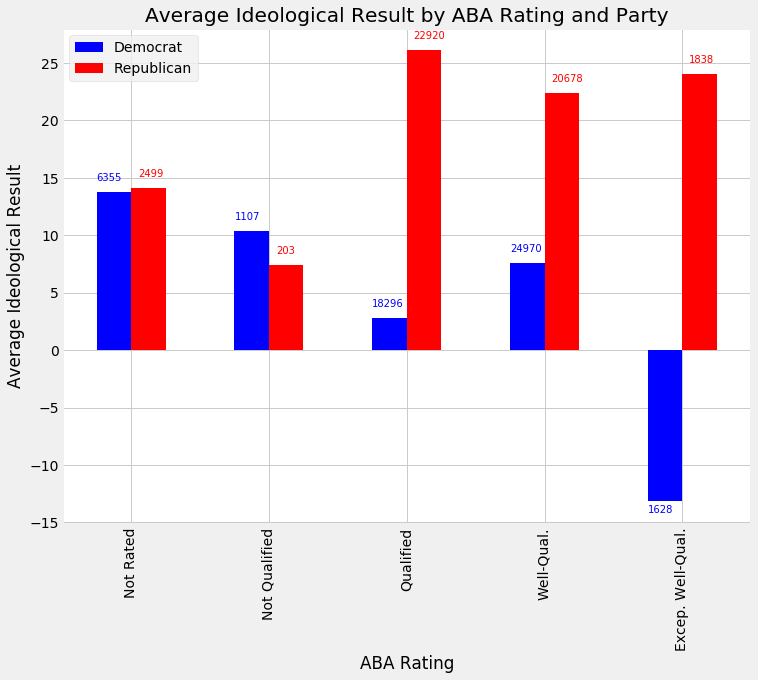

In [49]:
ideology_by_rating = (judge_decisions[judge_decisions['ABA Rating'].isin(
                                      ['Not Rated','Well-Qual.','Qualified','Not Qualified','Excep. Well-Qual.']) &
                                      judge_decisions['Judge Party'].isin(['Democrat','Republican'])]
                      .groupby(['ABA Rating','Judge Party'])[['Decision Ideology']].mean()
                      .unstack().reset_index().reindex([2,1,3,4,0]))
ideology_by_rating.columns = ['ABA Rating','Democrat','Republican']

# Add counts of each rating-party pair
count_by_rating = (judge_decisions[judge_decisions['ABA Rating'].isin(
                                      ['Not Rated','Well-Qual.','Qualified','Not Qualified','Excep. Well-Qual.']) &
                                      judge_decisions['Judge Party'].isin(['Democrat','Republican'])]
                      .groupby(['ABA Rating','Judge Party'])[['Decision Ideology']].count().unstack().reset_index())
count_by_rating.columns = ['ABA Rating','Democrat Count','Republican Count']
ideology_by_rating = ideology_by_rating.merge(count_by_rating, on = 'ABA Rating')

fig, ax = plt.subplots(figsize=(11,8.5))
ax.set_facecolor('white')
ax.grid(False)
ideology_by_rating.plot(kind = 'bar', x = 'ABA Rating', y = ['Democrat','Republican'], ax = ax, color =['b','r'])
ax.set_title("Average Ideological Result by ABA Rating and Party")
ax.set_ylabel("Average Ideological Result")
for i, v in enumerate(ideology_by_rating['Democrat'].values):
    text = ideology_by_rating[ideology_by_rating['Democrat'] == v]['Democrat Count'].iloc[0]
    if v > 0:
        ax.text(i - 0.25 , v + 1, text, color='b', fontdict = {'size': 10})
    else: 
        ax.text(i - 0.25 , v - 1, text, color='b', fontdict = {'size': 10})
for i, v in enumerate(ideology_by_rating['Republican'].values):
    text = ideology_by_rating[ideology_by_rating['Republican'] == v]['Republican Count'].iloc[0]
    if v > 0:
        ax.text(i + 0.05, v + 1, text, color='r', fontdict = {'size': 10})
    else: 
        ax.text(i + 0.05, v - 1, text, color='r', fontdict = {'size': 10})

There is practically no difference in decision-making between judges that are not rated or not qualified, according to the ABA. However, we see that qualified, well-qualified, and exceptionally well-qualified judges are much more likely to default to their own ideology! Exceptionally well-qualified democratic judges hold this bias so hard that their mean decision is liberal, despite mean decisions generally being conservative. It seems that more qualified judges are also more ideological.

## Some Prediction

Visually, it seems that a combination of factors, including case type, year, judge party, appointing president, ABA rating, gender and ethnicity, are determining factors in how judges make decisions. We ask one final question: is this complete? That is to say, do these factors combined account for everything? We run some statistical models to find out.

In [50]:
# We clean the data some more and take a new subset with more factors
decisions = decision_data[list(judge_decisions) + ['House Democrats','House Republicans','Senate Democrats',
                                                   'Senate Republicans','House Independents','Senate Independents',
                                                   'Recess Appointment']]
decisions = decisions.drop(columns = ['Authoring Judge'])
decisions = decisions.dropna()

# We again convert the decision ideology, which is either liberal or conservative, into a dummy.
def libcon_dummy(ideology):
    if ideology == 'Conservative':
        return 1
    if ideology == 'Liberal':
        return 0
    else:
        return np.nan
decisions['Decision Ideology'] = decisions['Decision Ideology'].apply(libcon_dummy)

# Categorical variables
categories_dec = ['Court Location', 'Circuit', 'Case Type', 'Case Category', 'Appointing President', 'Judge Party', 'Gender',
              'Race', 'ABA Rating', 'Congress', 'Unity', 'Recess Appointment']

# Continuous variables 
continuous_variables_dec = list(filter(lambda col: col not in categories_dec + ['Decision Ideology'], list(decisions)))

# Split into test and train
X_dec_train, X_dec_test, y_dec_train, y_dec_test = prep_data(
    decisions, continuous_variables_dec, categories_dec, 'Decision Ideology'
)

# A bunch of different models
alphas = np.exp(np.linspace(-2., -12., 25))
lr_model = linear_model.LinearRegression(n_jobs = 100)
logistic_model = linear_model.LogisticRegression(solver="liblinear", max_iter = 1000, n_jobs = 100)
lasso_model = linear_model.LassoCV(cv=6, alphas = alphas,  max_iter=500, n_jobs = 100)
forest_model = RandomForestRegressor(n_estimators = 100, n_jobs = 100)
nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),  # this will do the input scaling
    neural_network.MLPRegressor((150,),activation = "logistic",
                                solver="adam",alpha=0.005))
models = { "OLS": lr_model, "Logistic": logistic_model, "Lasso": lasso_model,
          "Random Forest": forest_model, "Neural Network":nn_scaled_model}

MSE_by_model = pd.DataFrame(index = models.keys(),
                            columns= ["Train MSE","Test MSE"])

mse_list = [fit_and_report_mses(model,X_dec_train, X_dec_test, y_dec_train, y_dec_test) for model in models.values()]

MSE_by_model['Train MSE'] = ['%f' % result["mse_train"] for result in mse_list]
MSE_by_model['Test MSE'] = ['%f' % result["mse_test"] for result in mse_list]
MSE_by_model

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 100.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-package

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



Train MSE              Test MSE
OLS             0.216954  3045509606943.511719
Logistic        0.348573              0.351613
Lasso           0.217721              0.219440
Random Forest   0.063066              0.240465
Neural Network  0.176032              0.226521

In [55]:
dev = st.stdev(decisions['Decision Ideology'])
print(f'The standard deviation for decision ideology is {dev}.')

The standard deviation for decision ideology is 0.4953091925451147.


OLS does a terrible job of predicting the data! Clearly the relationship between these factors and judge decision making is not linear. However, when fed into logistic regression, lasso, random forests, and neural networks, the predictive capacity becomes extremely strong! All MSEs are much lower than the standard deviation. Clearly there is strong predictive power from these attributes.

We unfortunately do not estimate nuisance function due to the complications induced by the fact that our regressors of interest are categorical as opposed to dummy variables.